In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.model_selection import train_test_split
import random
import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
%matplotlib inline

## Applying the logistic regression method

In [2]:
#load the data
data = pd.read_csv('bioresponse.csv')

y = data.Activity.values
x = data.iloc[:, 1:].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
x_train = x_train.T
x_test = x_test.T

In [3]:
# sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1./(1.+np.exp(-z))

    return s

In [4]:
# initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.

    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)

    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    w = np.zeros((dim,1))
    b = 0.

    return w, b

In [5]:
# propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size which equals the number of features
    b -- bias, a scalar
    X -- data
    Y -- true "label" vector (containing 0 and 1) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b

    """
    m = X.shape[1]
    #print('number of objects = ',len(X))

    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b )                                 # compute activation
    cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)   # compute cost

    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1./m)*np.dot(X,(A-Y).T)
    db = (1./m)*np.sum(A-Y,axis=1)

    grads = {"dw": dw,
             "db": db}

    return grads, cost

In [6]:
# Gradient Descent optimization

def optimize_GD(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm

    Arguments:
    w -- weights, a numpy array
    b -- bias, a scalar
    X -- data
    Y -- true "label" vector (containing 0 and 1), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps

    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

    """

    costs = []

    for i in range(num_iterations):

        # Cost and gradient calculation
        grads, cost = propagate(w,b,X,Y) ####

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        # update rule
        w -=learning_rate*dw
        b -=learning_rate*db

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

In [7]:
# predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

    Arguments:
    w -- weights, a numpy array
    b -- bias, a scalar
    X -- data

    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''

    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)

    # Compute vector "A" predicting the probabilities
    A = sigmoid(np.dot(w.T,X)+b)

    for i in range(A.shape[1]):

        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if (A[0,i]<=0.5):
            Y_prediction[0][i]=0
        else:
            Y_prediction[0][i]=1

    return Y_prediction

In [8]:
# model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False, method=optimize_GD):
    """
    Builds the logistic regression model by calling the function we've implemented previously

    Arguments:
    X_train -- training set represented by a numpy array
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations

    Returns:
    d -- dictionary containing information about the model.
    """

    # initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    if method =='ADAM':
      parameters, grads, costs = optimize_ADAM(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    elif method =='SGD':
      parameters, grads, costs = optimize_SGD(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    else:
      parameters, grads, costs = optimize_GD(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)


    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]

    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    if print_cost:
      print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
      print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

    return d

In [9]:
# Running the model
ans = model(x_train, y_train, x_test, y_test, num_iterations = 2000, learning_rate = 0.001, print_cost = True)


Cost after iteration 0: 0.693147
Cost after iteration 100: 0.678956
Cost after iteration 200: 0.671388
Cost after iteration 300: 0.664732
Cost after iteration 400: 0.658592
Cost after iteration 500: 0.652883
Cost after iteration 600: 0.647550
Cost after iteration 700: 0.642549
Cost after iteration 800: 0.637844
Cost after iteration 900: 0.633404
Cost after iteration 1000: 0.629203
Cost after iteration 1100: 0.625219
Cost after iteration 1200: 0.621434
Cost after iteration 1300: 0.617828
Cost after iteration 1400: 0.614389
Cost after iteration 1500: 0.611102
Cost after iteration 1600: 0.607956
Cost after iteration 1700: 0.604939
Cost after iteration 1800: 0.602044
Cost after iteration 1900: 0.599260
train accuracy: 72.23604692499111 %
test accuracy: 68.7633262260128 %


## 2. Implemeting and applying Stochastic Gradient Descent and ADAM optimization methods

In [10]:
def optimize_SGD(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    costs = []

    for i in range(num_iterations):

        val = np.random.randint(0, X.shape[1])
        batch_x = X[:, val].reshape(-1, 1)
        batch_y = Y[val].reshape(-1, 1)

        grads, cost = propagate(w, b, batch_x, batch_y)

        dw = grads["dw"]
        db = grads["db"]

        w -= learning_rate * dw
        b -= learning_rate * db

        if i % 100 == 0:
            gr, new_cost = propagate(w, b, X, Y)
            costs.append(new_cost)

            if print_cost:
                print("Cost after iteration %i: %f" % (i, new_cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

In [11]:
ans = model(x_train, y_train, x_test, y_test, num_iterations = 2000, learning_rate = 0.001, print_cost = True, method = 'SGD')

Cost after iteration 0: 0.692341
Cost after iteration 100: 0.678421
Cost after iteration 200: 0.685344
Cost after iteration 300: 0.663838
Cost after iteration 400: 0.660900
Cost after iteration 500: 0.662384
Cost after iteration 600: 0.649986
Cost after iteration 700: 0.645001
Cost after iteration 800: 0.650128
Cost after iteration 900: 0.641041
Cost after iteration 1000: 0.634853
Cost after iteration 1100: 0.626799
Cost after iteration 1200: 0.627126
Cost after iteration 1300: 0.619072
Cost after iteration 1400: 0.616398
Cost after iteration 1500: 0.613202
Cost after iteration 1600: 0.608198
Cost after iteration 1700: 0.605724
Cost after iteration 1800: 0.602334
Cost after iteration 1900: 0.612753
train accuracy: 72.27159616068255 %
test accuracy: 68.23027718550107 %


In [12]:
# ADAM optimization

def optimize_ADAM(w, b, X, Y, num_iterations, learning_rate, print_cost = False):

    costs = []
    v = np.array([0,0])
    s = np.array([0,0])
    epsilon = 1e-8
    beta1 = 0.9
    beta2 = 0.999

    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        grad = np.array([grads['dw'],grads['db']],dtype=object)
        v = beta1 * v + (1 - beta1) * grad
        s = beta1 * s + (1 - beta1) * np.square(grad)
        vcor = v / (1 - np.power(beta1, i+1))
        scor = s / (1 - np.power(beta2, i+1))

        w -= learning_rate * vcor[0] / (np.sqrt(scor[0]) + epsilon)
        b -= learning_rate * vcor[1] / (np.sqrt(scor[1]) + epsilon)

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    params = {"w": w,
              "b": b}

    grads = {"dw": grad[0],
             "db": grad[1]}

    return params, grads, costs

In [13]:
ans = model(x_train, y_train, x_test, y_test, num_iterations = 2000, learning_rate = 0.001, print_cost = True, method = 'ADAM')

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.599459
Cost after iteration 200: 0.514887
Cost after iteration 300: 0.454691
Cost after iteration 400: 0.411456
Cost after iteration 500: 0.379364
Cost after iteration 600: 0.354596
Cost after iteration 700: 0.334618
Cost after iteration 800: 0.317863
Cost after iteration 900: 0.303607
Cost after iteration 1000: 0.291370
Cost after iteration 1100: 0.280759
Cost after iteration 1200: 0.271465
Cost after iteration 1300: 0.263228
Cost after iteration 1400: 0.255821
Cost after iteration 1500: 0.249078
Cost after iteration 1600: 0.242894
Cost after iteration 1700: 0.237199
Cost after iteration 1800: 0.231930
Cost after iteration 1900: 0.227028
train accuracy: 90.89939566299324 %
test accuracy: 73.02771855010661 %


## 3. Learning curves

In [14]:
learning_rates = [0.01, 0.005, 0.001, 0.0005, 0.0001]
results = {}
optimizer_names = ["GD", "SGD", "ADAM"]

for name in optimizer_names:
    results[name] = {}
    for lr in learning_rates:
        # print(f"\nOptimizer - {name},lr = {lr}");
        d = model(x_train, y_train, x_test, y_test, num_iterations=2000, learning_rate=lr, print_cost=False, method=name)
        results[name][lr] = {
            "costs": d["costs"],
            "train_accuracy": 100 - np.mean(np.abs(d["Y_prediction_train"] - y_train)) * 100,
            "test_accuracy": 100 - np.mean(np.abs(d["Y_prediction_test"] - y_test)) * 100
        };

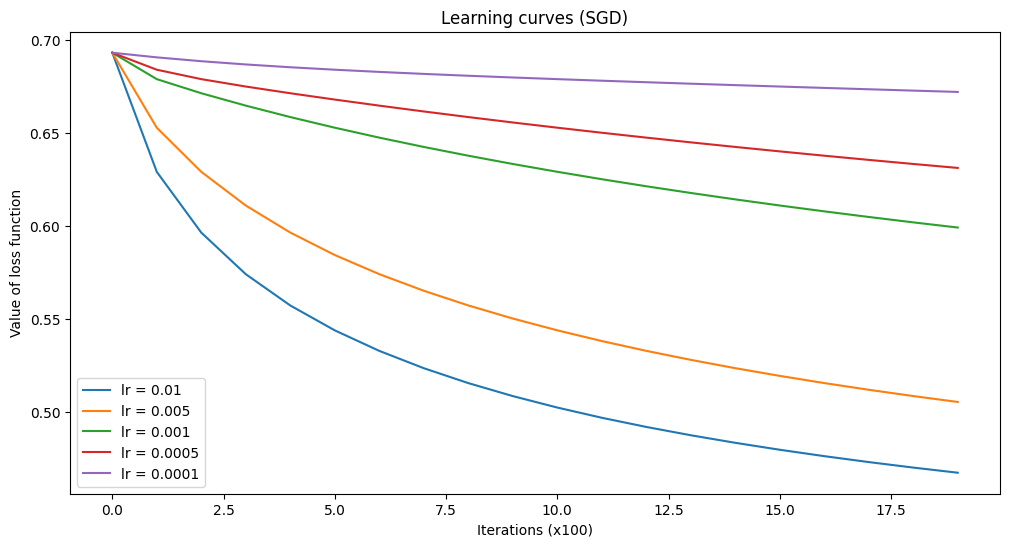

In [15]:
plt.figure(figsize=(12, 6))
for lr in learning_rates:
    plt.plot(results["GD"][lr]['costs'], label=f"lr = {lr}")
plt.title(f"Learning curves (SGD)")
plt.xlabel("Iterations (x100)")
plt.ylabel("Value of loss function")
plt.legend()
plt.show()

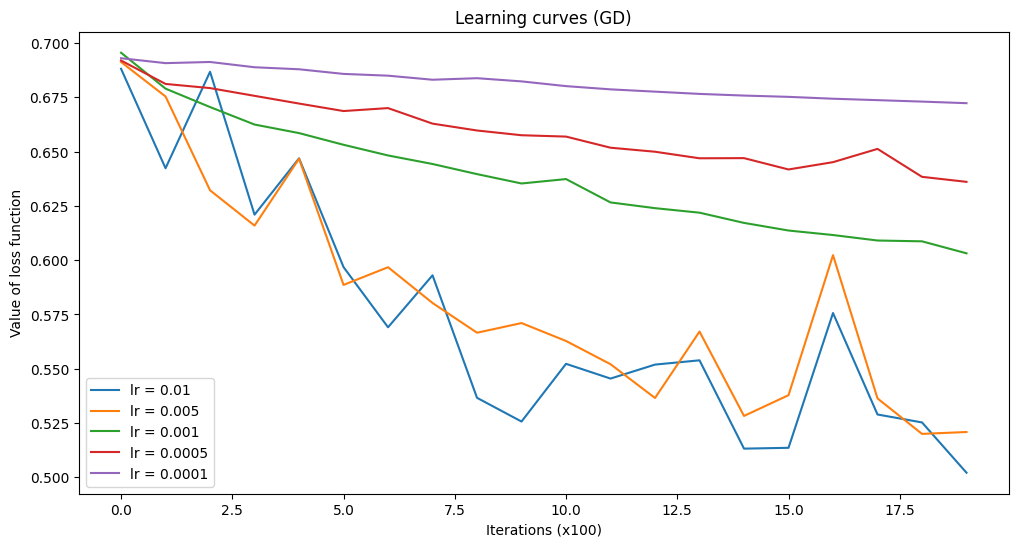

In [16]:
plt.figure(figsize=(12, 6))
for lr in learning_rates:
    plt.plot(results["SGD"][lr]['costs'], label=f"lr = {lr}")
plt.title(f"Learning curves (GD)")
plt.xlabel("Iterations (x100)")
plt.ylabel("Value of loss function")
plt.legend()
plt.show()

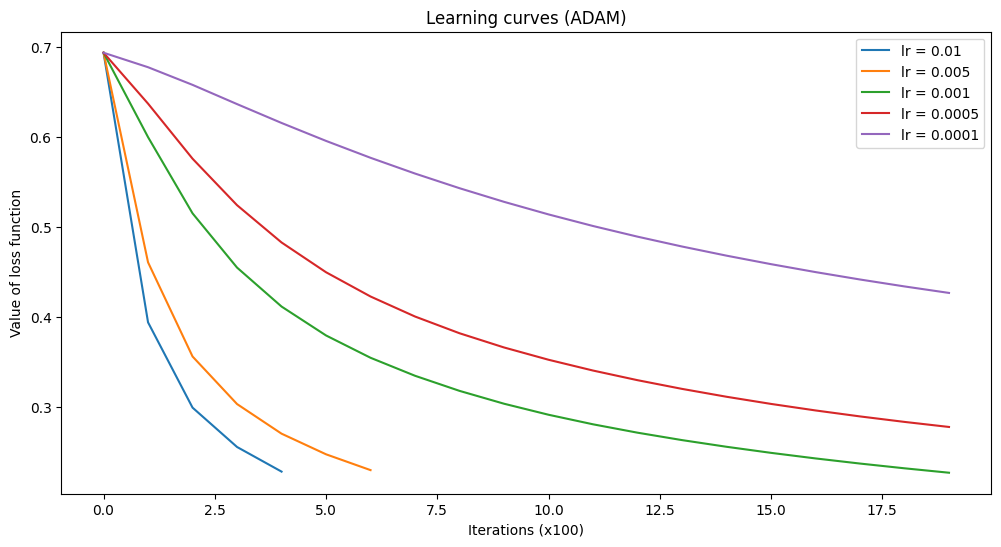

In [17]:
plt.figure(figsize=(12, 6))
for lr in learning_rates:
    plt.plot(results["ADAM"][lr]['costs'], label=f"lr = {lr}")
plt.title(f"Learning curves (ADAM)")
plt.xlabel("Iterations (x100)")
plt.ylabel("Value of loss function")
plt.legend()
plt.show()

Although models with higher learning rates can converge faster, they can lead to an overshoot and oscillation around the minima. At the same time low learning rates gradually lead to the optimal solution ignoring overshoots, but are rather slow and thei might not converge at all within the given number of iterations.

As it is seen from the graphs, models with ADAM and GD optimization work well with high learning rates, but SGD is oscillating. ADAM algorithm is the fastest of them. SGD works faster than GD because of smaller number of gradient evaluations.

## 4. Comparing the accuracy of the models

In [18]:
learning_rates = [0.01, 0.005, 0.001, 0.0005, 0.0001]
print('Results for GD')
for lr in learning_rates:
    print(f'''lr = {lr}, train_accuracy = {results['GD'][lr]['train_accuracy']}, test_accuracy = {results['GD'][lr]['test_accuracy']}''' )


Results for GD
lr = 0.01, train_accuracy = 79.34589406327764, test_accuracy = 75.3731343283582
lr = 0.005, train_accuracy = 77.31958762886597, test_accuracy = 73.77398720682302
lr = 0.001, train_accuracy = 72.23604692499111, test_accuracy = 68.7633262260128
lr = 0.0005, train_accuracy = 68.32563099893352, test_accuracy = 65.0319829424307
lr = 0.0001, train_accuracy = 56.843227870600785, test_accuracy = 58.2089552238806


In [19]:
learning_rates = [0.01, 0.005, 0.001, 0.0005, 0.0001]
print('Results for SGD')
for lr in learning_rates:
    print(f'''lr = {lr}, train_accuracy = {results['SGD'][lr]['train_accuracy']}, test_accuracy = {results['SGD'][lr]['test_accuracy']}''' )

Results for SGD
lr = 0.01, train_accuracy = 72.80483469605403, test_accuracy = 66.31130063965884
lr = 0.005, train_accuracy = 75.47102737291148, test_accuracy = 72.38805970149254
lr = 0.001, train_accuracy = 68.39672947031639, test_accuracy = 65.56503198294243
lr = 0.0005, train_accuracy = 65.12619978670459, test_accuracy = 63.53944562899787
lr = 0.0001, train_accuracy = 55.954496978314964, test_accuracy = 56.82302771855011


In [20]:
learning_rates = [0.01, 0.005, 0.001, 0.0005, 0.0001]
print('Results for ADAM')
for lr in learning_rates:
    print(f'''lr = {lr}, train_accuracy = {results['ADAM'][lr]['train_accuracy']}, test_accuracy = {results['ADAM'][lr]['test_accuracy']}''' )

Results for ADAM
lr = 0.01, train_accuracy = 96.87166725915392, test_accuracy = 72.0682302771855
lr = 0.005, train_accuracy = 95.41414859580519, test_accuracy = 73.13432835820896
lr = 0.001, train_accuracy = 90.89939566299324, test_accuracy = 73.02771855010661
lr = 0.0005, train_accuracy = 88.48204763597583, test_accuracy = 73.56076759061834
lr = 0.0001, train_accuracy = 81.72769285460362, test_accuracy = 72.49466950959489


The results show that increasing learning rate improves train accuracies for all of the models except SGD (due to overshoots), although the test accuracy varies. In GD test accuracies also gradually grow, in SGD the best solution is found with lr=0.0005, while test accuracies of ADAM remain quite the same (slightly more accurate with low lr) because of it's adaptive learning rate.


After comparing all of the models with different optimization algorithms, I can conclude that the best one for this task is the one with ADAM optimization and higher learning rate (in case we need faster convergence) and lower learning rates (if we need the highest test accuracy possible)